In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import loadmat
import json
import transformers
from transformers import BertModel, BertTokenizer
import torch
import pandas as pd
import math
# import seaborn as sns
from scipy.stats import pearsonr
import os
import pickle

/rds/general/user/ab5621/home/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def plot_brain_info(data, title):
    '''
    Plots timeseries of brain activity

    Parameters
    ----------
    data : np.ndarray 
        timeseries data representing brain activity 
    title : str
        title of the plot
    '''
    plt.figure(figsize=(10, 6))  
    plt.plot(data, label='Value', color='blue') 
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('fMRI Data')
    plt.grid(True)
    plt.savefig(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Plots/brain_responses_{title}.png')
    plt.show()

In [ ]:
def split_subjects_by_films(i):
    '''
    Splitting subjects by the film they have watched out of the 10 films available

    Parameters
    ----------
    i (int) :subject id 
    '''
    all_film_paths_dict = {'5470':[], '6804':[],'7715':[],'6674':[], '5900':[], '7515':[], '8882':[], '8181':[], '6739':[], '6102':[]}
    data=loadmat(f'/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200/sub-{i}/full_ts.mat')
    data = data['data']
    data = np.mean(data, axis=0)
    
    for film_length in all_film_paths_dict.keys():
        if len(data) == int(film_length):
            all_film_paths_dict[film_length].append(i)
    
    

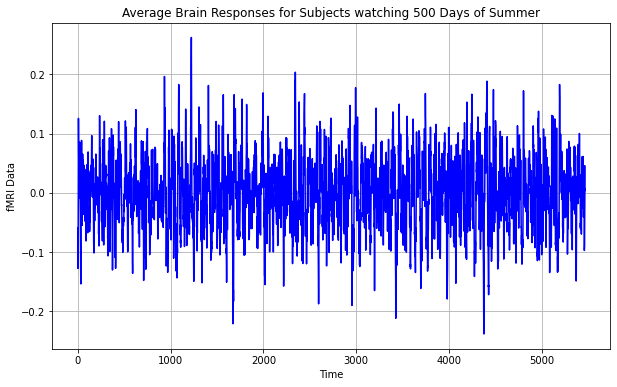

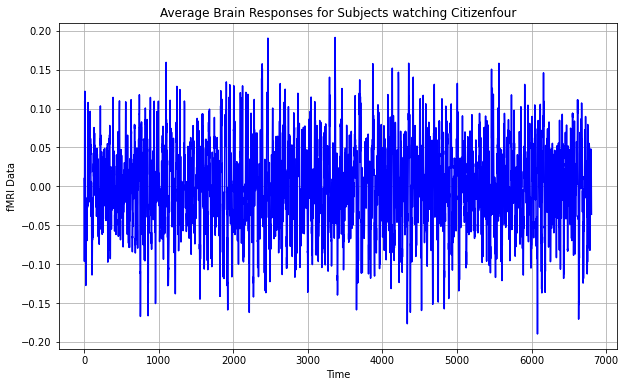

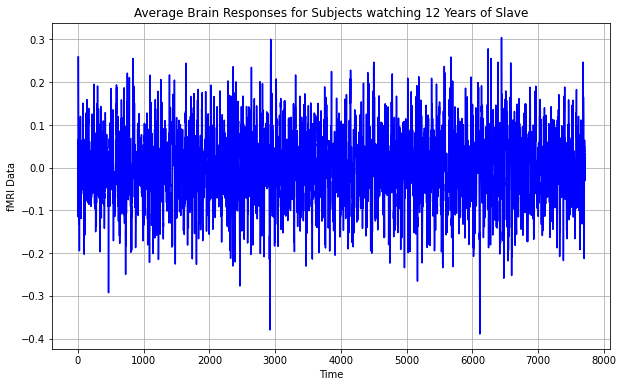

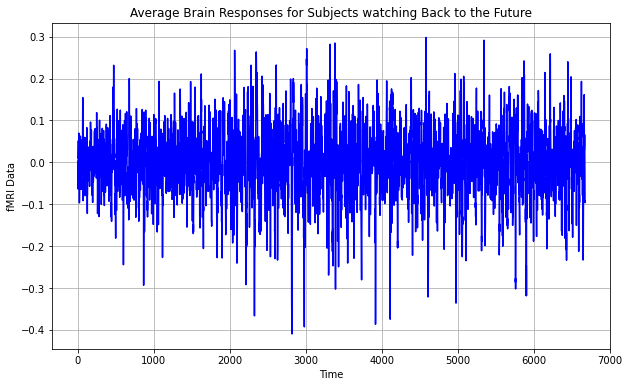

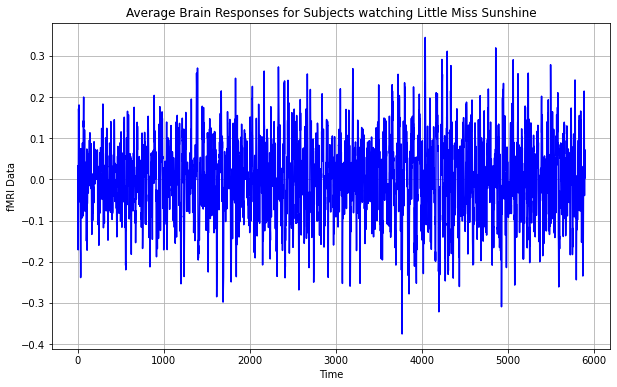

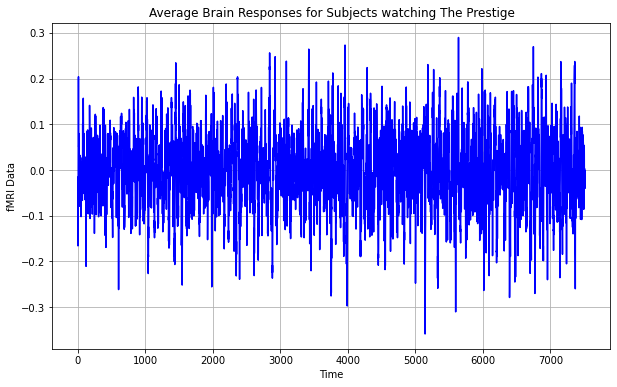

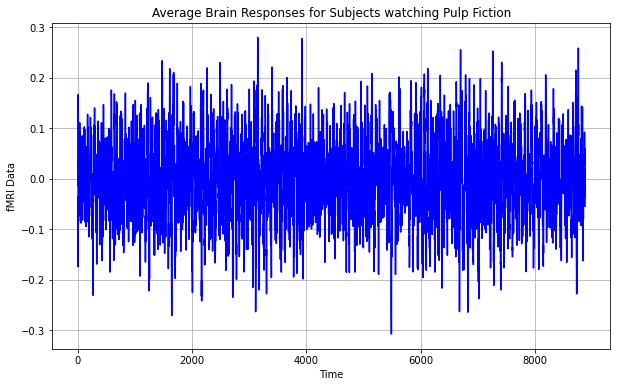

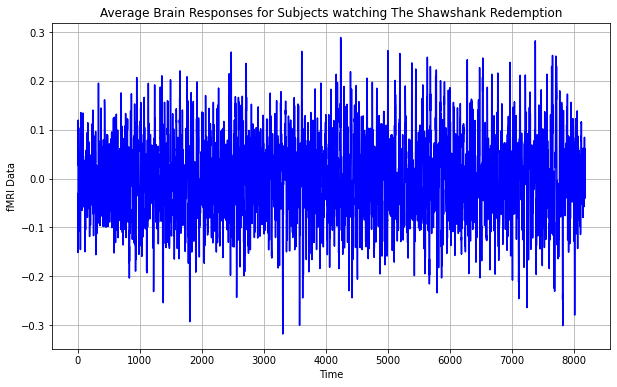

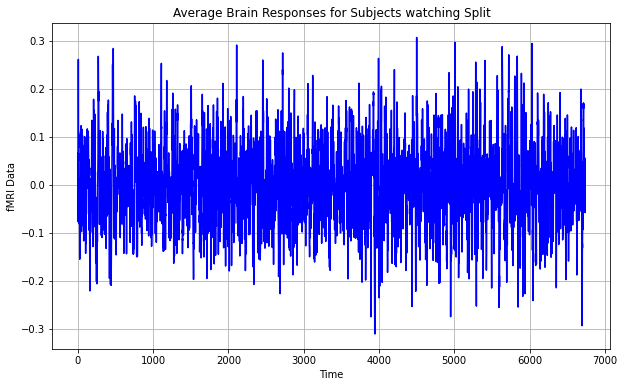

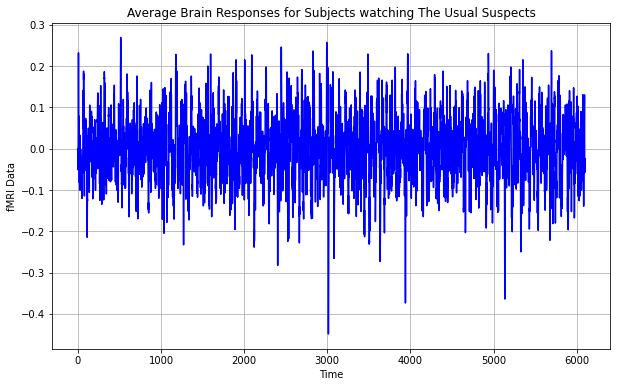

In [31]:
def plot_each_film():
    '''
    Plots average brain activity for all subjects watching the same film
    '''
    all_film_paths_dict = {'5470':[], '6804':[],'7715':[],'6674':[], '5900':[], '7515':[], '8882':[], '8181':[], '6739':[], '6102':[]}
    for i in range(1,87):
        split_subjects_by_films(i)
    for film_length in all_film_paths_dict.keys():
        all_data = np.zeros((int(film_length),))
        for i in all_film_paths_dict[film_length]:
            data=loadmat(f'/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200/sub-{i}/full_ts.mat')
            data = data['data']
            data = np.mean(data, axis=0)
            all_data += data
        all_data = all_data / len(all_film_paths_dict[film_length])
        if film_length == '5470':
            movie_context_path = '500 Days of Summer'
        if film_length == '6804':
            movie_context_path = 'Citizenfour'
        if film_length == '7715':
            movie_context_path = '12 Years of Slave'
        if film_length == '6674':
            movie_context_path = 'Back to the Future'
        if film_length == '5900':
            movie_context_path = 'Little Miss Sunshine'
        if film_length == '7515':
            movie_context_path = 'The Prestige'
        if film_length == '8882':
            movie_context_path = 'Pulp Fiction'
        if film_length == '8181':
            movie_context_path = 'The Shawshank Redemption'
        if film_length == '6739':
            movie_context_path = 'Split'
        if film_length == '6102':
            movie_context_path = 'The Usual Suspects'
        plot_brain_info(data=all_data, title = f'Average Brain Responses for Subjects watching {movie_context_path}')

plot_each_film()

In [6]:
def attention_scores_per_timepoint(film_path):
    '''
    Getting attention values for each timepoint (second)

    Parameters
    ----------
    film_path : str
        local JSON file containing attention values

    Returns
    -------
    target_variables_with_time : dict
        dictionary where the keys are timepoints and the values are the averaged attention scores 

    '''
    with open(film_path) as file:
        attention_for_film = json.load(file)
    
    new_attention_for_film = [[math.floor(float(key)), value[1]] for key, value in attention_for_film.items()]
    
    target_variables_with_time = {key: [] for key, _ in new_attention_for_film}

    for word_attention in new_attention_for_film:
        target_variables_with_time[word_attention[0]].append(word_attention[1])
    
    #Averaging context values between TR-1 and TR
    target_variables_with_time = {key: sum(values) / len(values) for key, values in target_variables_with_time.items()}


    return target_variables_with_time

In [12]:
def data_per_timepoint():
    '''
    Chopping up the BOLD signals to only contain timepoints where a word was spoken in the films
    '''
    #grouping subjects by the film they have watched
    all_film_paths_dict = {'5470':[], '6804':[],'7715':[],'6674':[], '5900':[], '7515':[], '8882':[], '8181':[], '6739':[], '6102':[]}

    for i in range(1,87):
        split_subjects_by_films(i)

    for film_length in all_film_paths_dict.keys():
        if film_length == '5470':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_500_days_of_summer.pkl'
        if film_length == '6804':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_citizenfour.pkl'
        if film_length == '7715':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_12_years_of_slave.pkl'
        if film_length == '6674':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_back_to_the_future.pkl'
        if film_length == '5900':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_little_miss_sunshine.pkl'
        if film_length == '7515':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_the_prestige.pkl'
        if film_length == '8882':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_pulp_fiction.pkl'
        if film_length == '8181':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_the_shawshank_redemption.pkl'
        if film_length == '6739':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_split.pkl'
        if film_length == '6102':
            movie_context_path = '/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/surp_per_timepoint_the_usual_suspects.pkl'
        
        #getting the timepoints where there is a spoken word
        with open(movie_context_path, 'rb') as f:
            surprisal_data = pickle.load(f)
        timepoints_with_words = list(surprisal_data.keys())
        timepoints_with_words = [timepoint-1 for timepoint in timepoints_with_words] #timepoint-1 so we can get the timepoint'th datapoint

        #taking only the rows where a word has been spoken
        for subject_id in all_film_paths_dict[film_length]:
            print(subject_id)
            data=loadmat(f'/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200/sub-{subject_id}/full_ts.mat')
            data = data['data']
            data = np.array(data)
            print(data.shape)
            #chopping up the fMRI data to contain only timepoints where a word was spoken
            data = data[:,timepoints_with_words]

            np.savetxt(f'/rds/general/user/ab5621/home/Masters-Dissertation/movie_subtitles/surprisal/fMRI_sub_{subject_id}_spoken_timepoints_new.csv', data, delimiter=',')

1
(232, 5470)
2
(232, 5470)
3
(232, 5470)
4
(232, 5470)
5
(232, 5470)
6
(232, 5470)
7
(232, 5470)
8
(232, 5470)
9
(232, 5470)
10
(232, 5470)
11
(232, 5470)
12
(232, 5470)
13
(232, 5470)
14
(232, 5470)
15
(232, 5470)
16
(232, 5470)
17
(232, 5470)
18
(232, 5470)
19
(232, 5470)
20
(232, 5470)
21
(232, 6804)
22
(232, 6804)
23
(232, 6804)
24
(232, 6804)
25
(232, 6804)
26
(232, 6804)
27
(232, 6804)
28
(232, 6804)
29
(232, 6804)
30
(232, 6804)
31
(232, 6804)
32
(232, 6804)
33
(232, 6804)
34
(232, 6804)
35
(232, 6804)
36
(232, 6804)
37
(232, 6804)
38
(232, 6804)
81
(232, 7715)
82
(232, 7715)
83
(232, 7715)
84
(232, 7715)
85
(232, 7715)
86
(232, 7715)
63
(232, 6674)
64
(232, 6674)
65
(232, 6674)
66
(232, 6674)
67
(232, 6674)
68
(232, 6674)
75
(232, 5900)
76
(232, 5900)
77
(232, 5900)
78
(232, 5900)
79
(232, 5900)
80
(232, 5900)
57
(232, 7515)
58
(232, 7515)
59
(232, 7515)
60
(232, 7515)
61
(232, 7515)
62
(232, 7515)
45
(232, 8882)
46
(232, 8882)
47
(232, 8882)
48
(232, 8882)
49
(232, 8882)
50
(

In [9]:

def plot_timeseries(data):
    '''
    Plots the activity of each brain region separatelty
    '''
    no_brain_regions = data.shape[0]
    time = np.linspace(start=0, stop=data.shape[1], num=data.shape[1]) 

    fig, ax = plt.subplots(figsize=(10, 8))
    offset = 3 
    gap_start_region = 4
    gap_end_region = data.shape[0]

    # Plot channels before the gap
    for i in range(gap_start_region):
        ax.plot(time, data[i] + i * offset, label=f'Brain Region {i+1}')

    # Plot channel after the gap
    ax.plot(time, data[-1] + (gap_start_region + 1) * offset, label='Brain Region 64')

    ax.set_xlabel('Time (s)')
    yticks = [i * offset for i in range(gap_start_region)] + [(gap_start_region + 1) * offset]
    yticklabels = [f'Brain Region {i+1}' for i in range(gap_start_region)] + ['Brain Region 232']
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlim([0,data.shape[1] ])
    ax.set_ylim([-offset, (gap_start_region + 2) * offset])
    ax.set_title('Brain Responses for Each Brain Region (Subject 85)')

    # Adding the gap between the channels
    mid_gap_y = ((gap_start_region + 1) * offset) - offset / 2  - 2
    ax.text(data.shape[1]/2, mid_gap_y, '•\n•\n•', ha='center', va='center', fontsize=20, color='black')
    # plt.savefig('/rds/general/user/ab5621/home/Masters-Dissertation/Results/Plots/timeseries_only_spoken_timepoints_one_subj.pdf', dpi=300)
    plt.show()


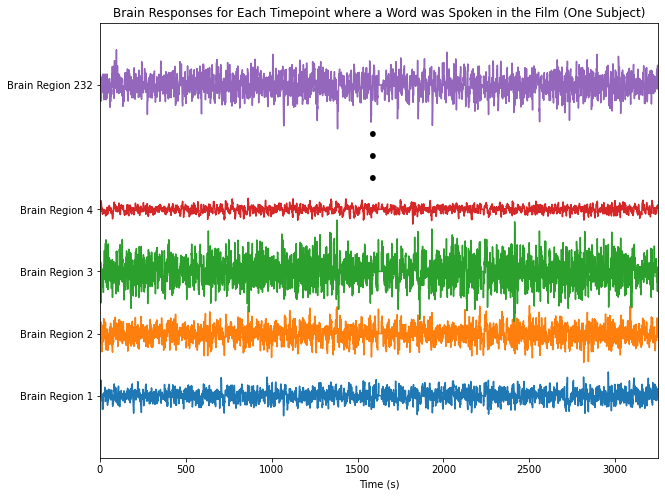

In [4]:
plot_timeseries(data =spoken_timepoints_fMRI)

In [7]:
fMRI_data = loadmat('/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200/sub-85/full_ts.mat')
fMRI_data = fMRI_data['data']
fMRI_data = np.array(fMRI_data)
print(fMRI_data.shape)

(232, 7715)


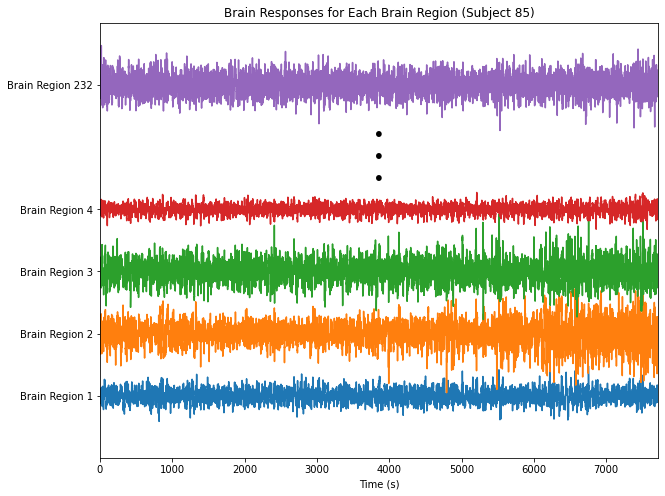

In [10]:
plot_timeseries(fMRI_data)